In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2                  # OpenCV library for image processing
import numpy as np  # NumPy for numerical operations on arrays/matrices
import pandas as pd
import matplotlib.pyplot as plt  # Matplotlib for visualizations
from sklearn.model_selection import train_test_split
import tensorflow as tf     # TensorFlow for deep learning models
import keras
from keras import layers
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras import regularizers
import os
import importlib
INTERPOLATION = cv2.INTER_CUBIC
NEW_SIZE = (400, 256)

In [ ]:
%run utils\mask_extraction.py

In [4]:
# Path to the folder containing images
folder_path = "/content/drive/MyDrive/license plate/images"

# Get list of files in the folder
file_list = os.listdir(folder_path)

# Filter the files to only include image files
image_files = [file for file in file_list if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png")]
images = {}

# Loop through each image file and read it using cv2.imread
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, NEW_SIZE, INTERPOLATION)
    image = np.expand_dims(image, axis=-1)
    images[image_file] = image/255.0

(256, 400, 1)


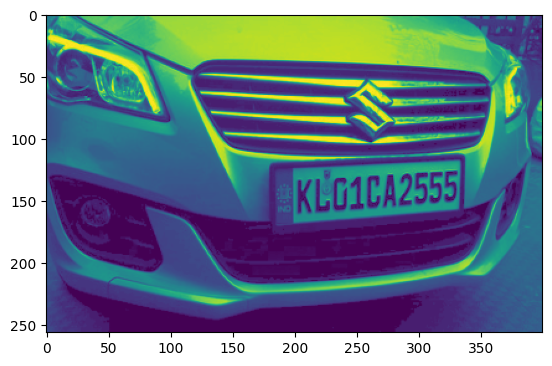

In [5]:
plt.imshow(images['Cars0.png'])
print(images['Cars0.png'].shape)

In [6]:
# Path to the folder containing images
folder_path = "/content/drive/MyDrive/license plate/masks"

# Get list of files in the folder
file_list = os.listdir(folder_path)

# Filter the files to only include image files
mask_files = [file for file in file_list if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png")]
masks = {}

# Loop through each image file and read it using cv2.imread
for mask_file in mask_files:
    mask_path = os.path.join(folder_path, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, NEW_SIZE, INTERPOLATION)
    mask = np.expand_dims(mask, axis=-1)
    masks[mask_file] = mask/255.0

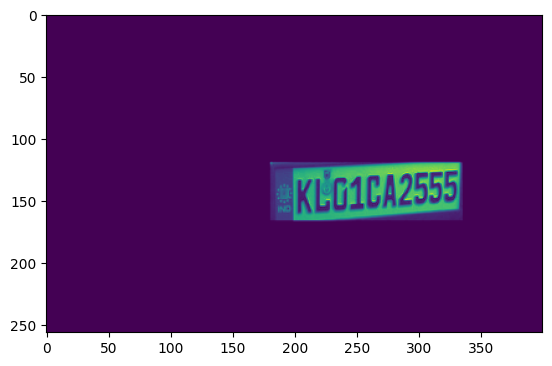

In [7]:
plt.imshow(masks['Cars0.png'])
plt.show()

In [8]:
data = []
for key, image in images.items():
    data.append(np.array([image, masks[key]]))

data = np.array(data)

In [9]:
def unet(input_shape):
    inputs = Input(shape=input_shape)

    # Encoding path
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Middle path
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoding path
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = Concatenate(axis=3)([drop4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    # Define model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy')

    return model

In [10]:
# Split the data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(data[:,0], data[:,1], test_size=0.2, random_state=42)

In [11]:
len(train_images)

346

In [25]:
input_shape = (256, 400, 1)
segment_model = unet(input_shape)

In [26]:
segment_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 400, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 400, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 256, 400, 64  36928       ['conv2d_23[0][0]']              
                                )                                                           

In [27]:
# Train the model
segment_model.fit(train_images, train_masks, batch_size=16, epochs=20, validation_data=(val_images, val_masks))

Epoch 1/20
22/22 [==============================] - 49s 2s/step - loss: 59.1072 - val_loss: 0.1943
Epoch 2/20
22/22 [==============================] - 40s 2s/step - loss: 0.1821 - val_loss: 0.1861
Epoch 3/20
22/22 [==============================] - 40s 2s/step - loss: 0.1448 - val_loss: 0.1534
Epoch 4/20
22/22 [==============================] - 40s 2s/step - loss: 0.1240 - val_loss: 0.1409
Epoch 5/20
22/22 [==============================] - 40s 2s/step - loss: 0.1021 - val_loss: 0.1255
Epoch 6/20
22/22 [==============================] - 40s 2s/step - loss: 0.0939 - val_loss: 0.1092
Epoch 7/20
22/22 [==============================] - 40s 2s/step - loss: 0.0845 - val_loss: 0.0967
Epoch 8/20
22/22 [==============================] - 40s 2s/step - loss: 0.0779 - val_loss: 0.0943
Epoch 9/20
22/22 [==============================] - 40s 2s/step - loss: 0.0756 - val_loss: 0.1071
Epoch 10/20
22/22 [==============================] - 40s 2s/step - loss: 0.0819 - val_loss: 0.0972
Epoch 11/20
22/22 

In [28]:
tf.keras.models.save_model(segment_model, "segment_model_1.h5")

In [29]:
pred = segment_model.predict(val_images)

3/3 [==============================] - 2s 840ms/step


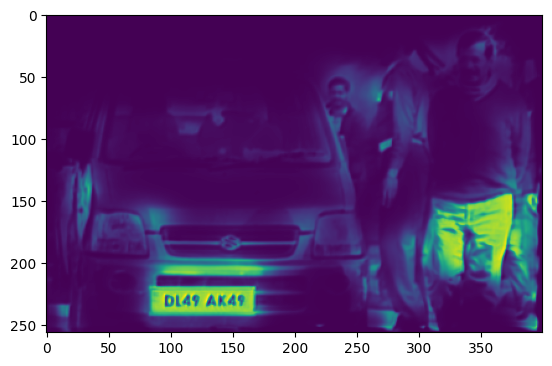

In [40]:
plt.imshow(pred[4])

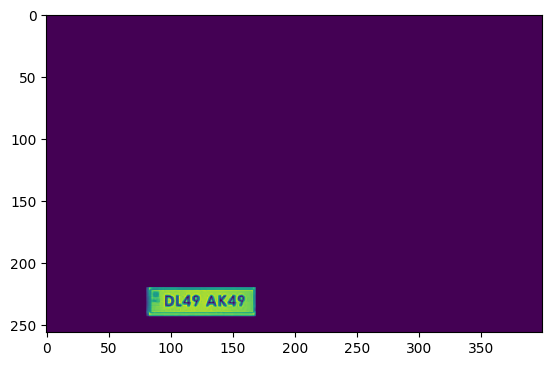

In [41]:
plt.imshow(val_masks[4])

In [44]:
def iou(pred, target):
  iou_score=0.0
  for p,t in zip(pred, target):
    intersection = np.logical_and(t, p)
    union = np.logical_or(t, p)
    iou_score += np.sum(intersection) / np.sum(union)
  return iou_score

In [45]:
print(iou(pred, val_masks))

4.469682014627256
